In [1]:
import pandas as pd
import base64
from openai import OpenAI
import json
from pydantic import BaseModel
import cv2
import numpy as np
import fitz
from PIL import Image
from io import BytesIO
pd.set_option('display.max_columns', None)
from typing import Optional
import matplotlib.pyplot as plt
import json


import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment, Border, Side, Font

In [2]:
def get_contours(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Инвертируем изображение (пунктирные линии должны быть белыми)
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Применяем размытие, чтобы убрать шум
    blurred = cv2.GaussianBlur(binary, (5, 5), 0)

    # Используем морфологию для выделения прямоугольных структур
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    processed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Поиск контуров
    contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: x[0][0][1])
    contours = sorted(contours, key=lambda x: x[0][0][0])
    contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))

    # Копия изображения для отображения результатов
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Фильтруем и выделяем только прямоугольные блоки
    contours_valid = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Условие для фильтрации блоков по размеру
        if 100 < w < 150 and 100 < h < 200:  # Подстраивайте размеры под бланк
            contours_valid.append(contour)
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return contours_valid, output

def visualize_row(contours, image_path):
    # Копия изображения для отображения результатов
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Фильтруем и выделяем только прямоугольные блоки
    contours_valid = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Условие для фильтрации блоков по размеру
        if 100 < w < 150 and 100 < h < 200:  # Подстраивайте размеры под бланк
            contours_valid.append(contour)
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return output
    
def get_aligned_pic(template_path, filled_form_path, scale_factor = 0.25):

    # 1. Считываем два изображения
    template = cv2.imread(template_path, 0)   # шаблон (пустой бланк)
    height, width = template.shape
    template = cv2.resize(template, (int(height*scale_factor), int(width*scale_factor)), interpolation=cv2.INTER_AREA)
    filled   = cv2.imread(filled_form_path, 0) # заполненный бланк

    # Приведение заполненного бланка к размеру и разрешению шаблона
    filled = cv2.resize(filled, (template.shape[1], template.shape[0]), interpolation=cv2.INTER_AREA)

    # Нахождение ключевых точек и дескрипторов
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(template, None)
    kp2, des2 = sift.detectAndCompute(filled, None)

    # Сопоставление точек
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Используем лучшие сопоставления
    good_matches = matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Вычисление матрицы гомографии
    matrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Применение перспективного преобразования
    h, w = template.shape
    aligned_image = cv2.warpPerspective(filled, matrix, (w, h))

    aligned_image = cv2.resize(aligned_image, (width, height), interpolation=cv2.INTER_AREA)
    # Сохранение результата
    cv2.imwrite('aligned_form.jpg', aligned_image)

    return aligned_image

In [4]:
contours, output = get_contours("template.jpg")


In [5]:
contours = contours[2:-2]

In [6]:
len(contours)


202

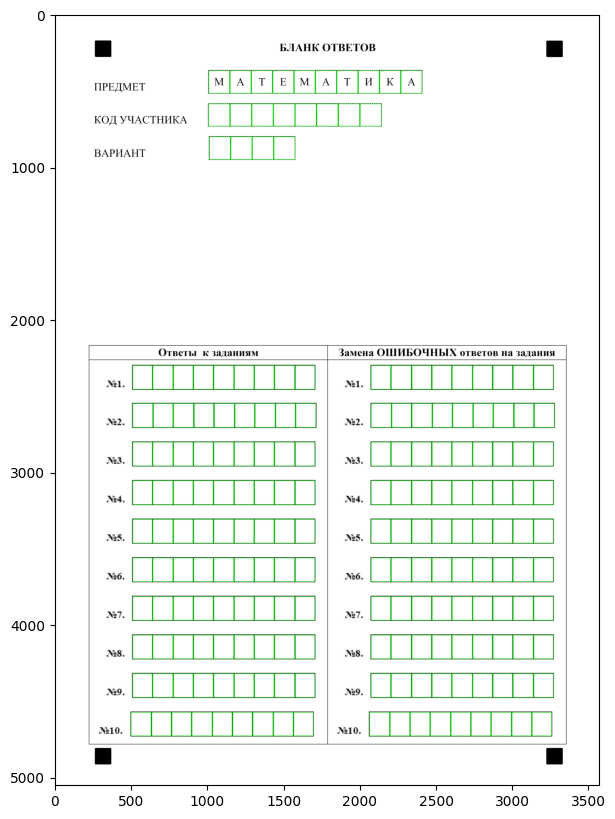

In [7]:
output1 = visualize_row(contours, "template.jpg")
# img = get_aligned_pic("test_pics/valid_format/template.jpg", "test_pics/valid_format/page-1.jpg", scale_factor = 0.3)
# output2 = visualize_row(contours, "aligned_form.jpg")
plt.figure(figsize=(10, 10))  # Make the plot bigger
plt.imshow(output1, cmap='gray')
# plt.imshow(output2, cmap='gray')
plt.show()


In [8]:
numb_cells_dict = {'subject':10,
                   'user_id':8,
                   'version':4,
                   'answer1':9,
                   'correction1':9,
                   'answer2':9,
                   'correction2':9,
                   'answer3':9,
                   'correction3':9,
                   'answer4':9,
                   'correction4':9,
                   'answer5':9,
                   'correction5':9,
                   'answer6':9,
                   'correction6':9,
                   'answer7':9,
                   'correction7':9,
                   'answer8':9,
                   'correction8':9,
                   'answer9':9,
                   'correction9':9,
                   'answer10':9,
                   'correction10':9}

contours, output = get_contours("template.jpg")
contours = contours[2:-2]


rows_dict = {}
j= 0 
for key, value in numb_cells_dict.items():
    rows_dict[key] = dict() 
    for i in range(value):
        rows_dict[key][i] = contours[j]
        j+=1


In [9]:
rows_processed_json = {}
for key in rows_dict.keys():
    rows_processed_json[key] = {}
    for i in range(len(rows_dict[key])):
        x, y, w, h = cv2.boundingRect(np.array(rows_dict[key][i]))
        rows_processed_json[key][f'cell{i}'] = dict(x=x, y=y, w=w, h=h, row_name=key, value=None, cell_number=i)

# save to json
with open('rows_data.json', 'w') as json_file:
    json.dump(rows_processed_json, json_file)



In [10]:
with open('rows_data.json', 'r') as json_file:
    rows_json = json.load(json_file)



In [11]:
rows_processed_json

{'subject': {'cell0': {'x': 1008,
   'y': 365,
   'w': 135,
   'h': 147,
   'row_name': 'subject',
   'value': None,
   'cell_number': 0},
  'cell1': {'x': 1148,
   'y': 365,
   'w': 135,
   'h': 147,
   'row_name': 'subject',
   'value': None,
   'cell_number': 1},
  'cell2': {'x': 1288,
   'y': 365,
   'w': 135,
   'h': 147,
   'row_name': 'subject',
   'value': None,
   'cell_number': 2},
  'cell3': {'x': 1428,
   'y': 365,
   'w': 135,
   'h': 147,
   'row_name': 'subject',
   'value': None,
   'cell_number': 3},
  'cell4': {'x': 1568,
   'y': 365,
   'w': 135,
   'h': 147,
   'row_name': 'subject',
   'value': None,
   'cell_number': 4},
  'cell5': {'x': 1708,
   'y': 365,
   'w': 135,
   'h': 147,
   'row_name': 'subject',
   'value': None,
   'cell_number': 5},
  'cell6': {'x': 1848,
   'y': 365,
   'w': 135,
   'h': 147,
   'row_name': 'subject',
   'value': None,
   'cell_number': 6},
  'cell7': {'x': 1988,
   'y': 365,
   'w': 135,
   'h': 147,
   'row_name': 'subject',
   'v